In [15]:
import os
import sys

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xarray as xr
import xesmf as xe
import xcdat as xc
import xsearch as xs
import xskillscore as xscore

from glob import glob 
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, Sequence, cast

# Ignore xarray warnings (bad practice)
import warnings
warnings.simplefilter("ignore") 

In [111]:
# SANITY CHECK Plotting
def global_plot(data, lon, lat, cmap, title="", levels=np.arange(-4, 4.1, .1)):
    # plot map of global data with central longitude 180
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
    img = ax1.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        extend="both",
        levels=levels,
    )
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    # East Pacific
    # bound_region(ax1, lons=(-180, -80), lats=(-10, 0), color="black")
    bound_region(ax1, lons=(-180, -80), lats=(-10, 0), color="black")
# eastFB = ds.sel(lon=slice(-180, -80), lat=slice(-10, 0)).spatial.average("fb")["fb"] # Observed definition 
    # West Pacific
    # bound_region(ax1, lons=(130, 150), lats=(0, 10), color="black")
    bound_region(ax1, lons=(140, 180), lats=(-5, 5), color="black")

# eastFB = ds.sel(lon=slice(-120, -80), lat=slice(-20, 10)).spatial.average("fb")["fb"] # Observed definition 
# westFB = ds.sel(lon=slice(140, 180), lat=slice(-5, 5)).spatial.average("fb")["fb"] # Observed definition 
# westFB - eastFB

        
    # "westPacific": ds.sel(lon=slice(110, 180), lat=slice(-5, 5)).spatial.average("tos")["tos"], 
    # "centralPacificNino4": ds.sel(lon=slice(-180, -150), lat=slice(-5, 5)).spatial.average("tos")["tos"], 
    # "westPacificHoell": ds.sel(lon=slice(130, 150), lat=slice(0, 10)).spatial.average("tos")["tos"], 
    # "eastPacificWills": ds.sel(lon=slice(-180, -80), lat=slice(-5, 5)).spatial.average("tos")["tos"], # Wills et. al definitions
    # "eastPacificSA": ds.sel(lon=slice(-110, -75), lat=slice(-30, 5)).spatial.average("tos")["tos"], # Kim region
    # "eastPacific": ds.sel(lon=slice(-125, -80), lat=slice(-5, 5)).spatial.average("tos")["tos"], # My definition
        
    ax1.coastlines()
    ax1.set_global()
    ax1.set_title(title)
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -45, 45
    ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    # Add a horizontal colorbar
    cbar = plt.colorbar(img, orientation='horizontal')
    plt.show()

def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )


In [3]:
def remove_land_full(ds, var="skt"):
    ds = xc.swap_lon_axis(ds, to=(-180, 180))
    from global_land_mask import globe
    # Set land to NaN
    lon_grid,lat_grid = np.meshgrid(ds.longitude, ds.latitude)
    globe_land_mask = globe.is_land(lat_grid,lon_grid)
    globe_land_mask_nd = np.tile(globe_land_mask,(ds[var].shape[0],1,1))
    ds_no_land = xr.where(globe_land_mask_nd==True,np.nan,ds[var]) 
    return ds_no_land


# Plot SST Trends

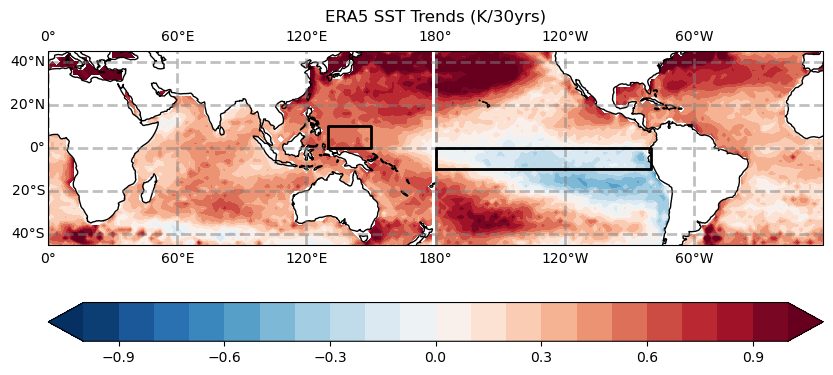

In [27]:
era5 = xc.open_dataset("data/obs/ts_mon_ERA5_197901-202212.nc")
era5 = remove_land_full(era5, var="skt")

time_idx = xr.DataArray(np.arange(len(era5.time)), dims=("time"))
era5_trends = xscore.linslope(time_idx, era5, dim="time")*12*30

# Plot ERA5 SST Trends
global_plot(era5_trends, era5_trends.longitude, era5_trends.latitude, levels=np.arange(-1,1.1,.1), cmap="RdBu_r", title="ERA5 SST Trends (K/30yrs)")

In [36]:
def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

era5_ds = fix_coords(era5.to_dataset() - 273)

era5_westPacificHoell = era5_ds.sel(longitude=slice(130, 150), latitude=slice(10, 0)).spatial.average("skt")["skt"]
era5_eastPacificObs = era5_ds.sel(longitude=slice(-180, -80), latitude=slice(0, -10)).spatial.average("skt")["skt"]
era5_WE = era5_westPacificHoell - era5_eastPacificObs

# Plot SWCRE Trends

In [5]:
def remove_land(ds, var="skt"):
    ds = xc.swap_lon_axis(ds, to=(-180, 180))
    from global_land_mask import globe
    # Set land to NaN
    lon_grid,lat_grid = np.meshgrid(ds.lon, ds.lat)
    globe_land_mask = globe.is_land(lat_grid,lon_grid)
    globe_land_mask_nd = np.tile(globe_land_mask,(ds[var].shape[0],1,1))
    ds_no_land = xr.where(globe_land_mask_nd==True,np.nan,ds[var]) 
    return ds_no_land


2023-07-25 09:47:24,765 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


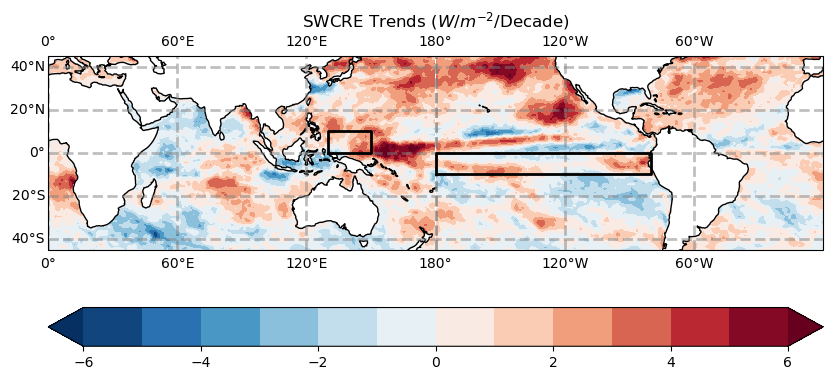

In [6]:
ceres = xc.open_dataset("data/obs/CERES_EBAF-TOA_Ed4.1_Subset_200003-202201.nc")
swas = remove_land(ceres, var="toa_sw_all_mon")
swcs = remove_land(ceres, var="toa_sw_clr_c_mon")
swcre = swcs - swas # Clear Sky minus All Sky

time_idx = xr.DataArray(np.arange(len(swcre.time)), dims=("time"))
swcre_trends = xscore.linslope(time_idx, swcre, dim="time")*12*10

# Plot ERA5 SST Trends
global_plot(swcre_trends, swcre_trends.lon, swcre_trends.lat, levels=np.arange(-6, 7, 1), cmap="RdBu_r", title=r"SWCRE Trends ($W/m^{-2}$/Decade)")

2023-07-25 09:47:28,354 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


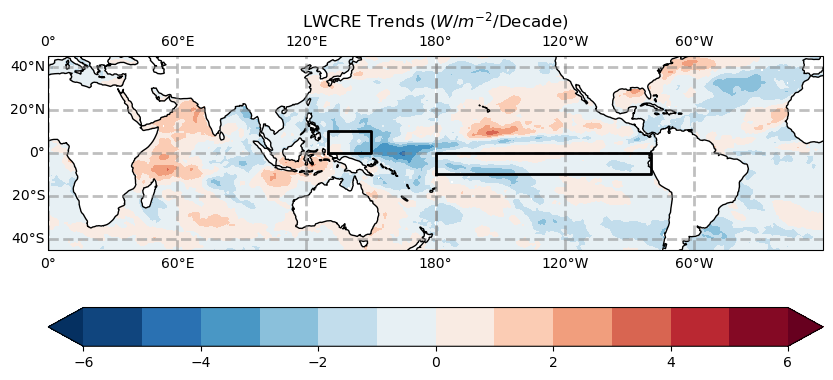

In [7]:
ceres = xc.open_dataset("data/obs/CERES_EBAF-TOA_Ed4.1_Subset_200003-202201.nc")
lwas = remove_land(ceres, var="toa_lw_all_mon")
lwcs = remove_land(ceres, var="toa_lw_clr_c_mon")
lwcre = lwcs - lwas # Clear Sky minus All Sky

time_idx = xr.DataArray(np.arange(len(lwcre.time)), dims=("time"))
lwcre_trends = xscore.linslope(time_idx, lwcre, dim="time")*12*10

# Plot ERA5 SST Trends
global_plot(lwcre_trends, lwcre_trends.lon, lwcre_trends.lat, levels=np.arange(-6, 7, 1), cmap="RdBu_r", title=r"LWCRE Trends ($W/m^{-2}$/Decade)")

2023-07-25 14:54:27,960 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


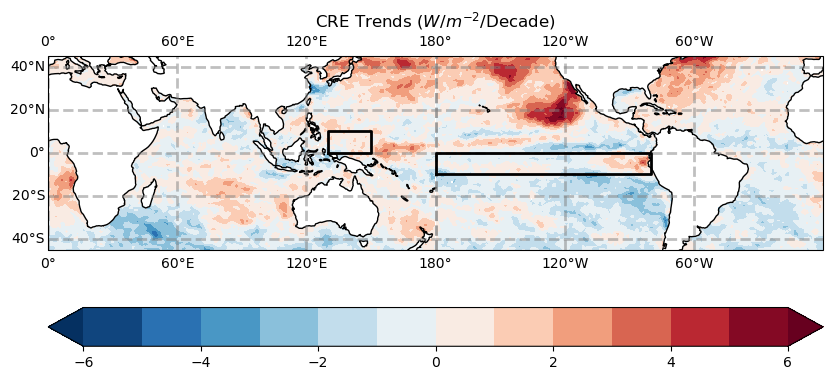

In [37]:
ceres = xc.open_dataset("data/obs/CERES_EBAF-TOA_Ed4.1_Subset_200003-202201.nc")
nas = remove_land(ceres, var="toa_net_all_mon")
ncs = remove_land(ceres, var="toa_net_clr_c_mon")
cre = -(ncs - nas) # Clear Sky minus All Sky (These are both incoming/downard fluxes, so we need to flip the sign)

time_idx = xr.DataArray(np.arange(len(cre.time)), dims=("time"))
cre_trends = xscore.linslope(time_idx, cre, dim="time")*12*10

# Plot ERA5 SST Trends
global_plot(cre_trends, cre_trends.lon, cre_trends.lat, levels=np.arange(-6, 7, 1), cmap="RdBu_r", title=r"CRE Trends ($W/m^{-2}$/Decade)")

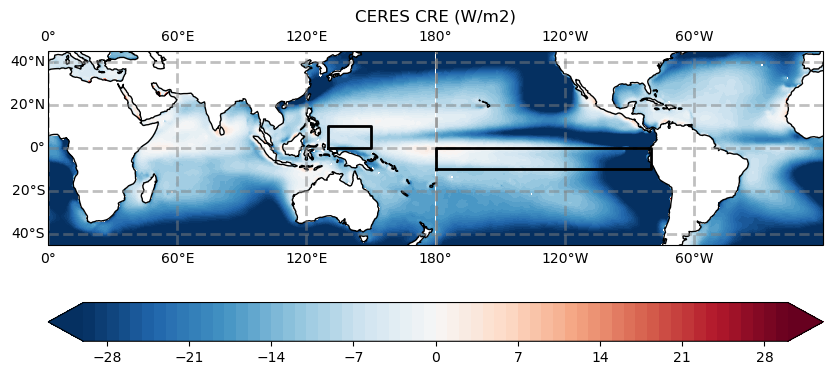

In [9]:
global_plot(cre.mean("time"), cre.lon, cre.lat, levels=np.arange(-30, 31, 1), cmap="RdBu_r", title="CERES CRE (W/m2)")

# Plot EIS Trends

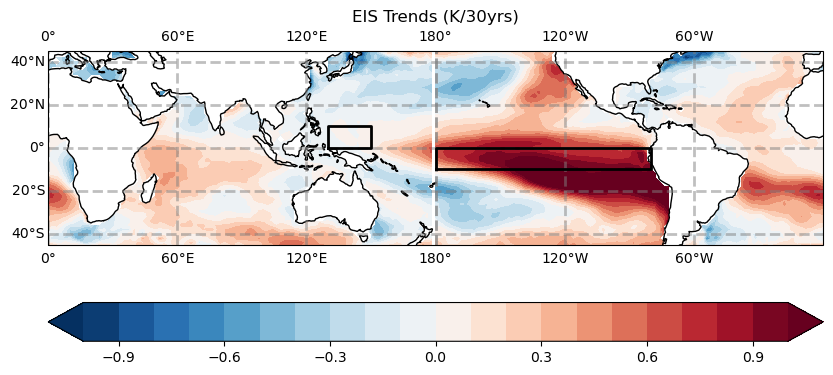

In [10]:
eis = xc.open_dataset("data/obs/EIS_mon_197901-202212_obs.nc")
eis = remove_land_full(eis, var="eis")

time_idx = xr.DataArray(np.arange(len(eis.time)), dims=("time"))
eis_trends = xscore.linslope(time_idx, eis, dim="time")*12*30

# Plot ERA5 SST Trends
global_plot(eis_trends, eis_trends.longitude, eis_trends.latitude, levels=np.arange(-1,1.1,.1), cmap="RdBu_r", title="EIS Trends (K/30yrs)")

# Plot dsst/dcre

In [104]:
cre["time"] = np.arange("2000-03", "2022-02", dtype="datetime64[M]")
era5_WE_c = era5_WE.sel(time=cre.time)
era5_WE_c["time"] = cre.time
dsstwedcre = xscore.linslope(cre, era5_WE_c, dim="time", skipna=True)
dsstwedcre = fix_coords(dsstwedcre.rename("fb").to_dataset())

lat = np.arange(-88.75, 90, 2.5)
lon = np.arange(-178.75, 180, 2.5)
output_grid = xc.create_grid(lat, lon)

# Regrid Data
dsstwedcre = dsstwedcre.regridder.horizontal("fb", output_grid, tool='xesmf', method='bilinear')["fb"]

2023-07-25 15:40:31,377 [WARNING]: bounds.py(_create_bounds:398) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


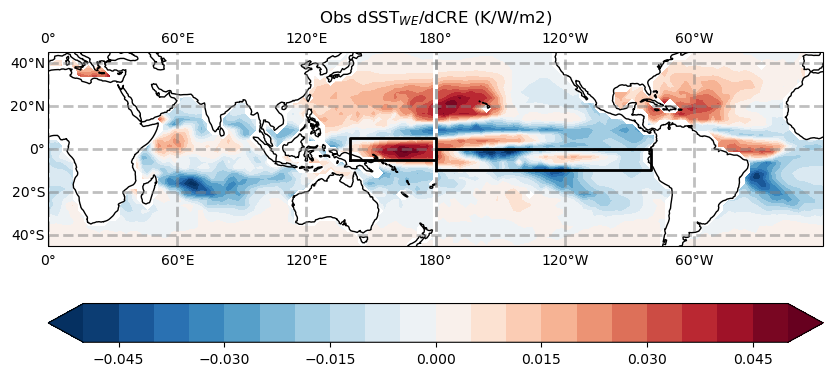

In [112]:
global_plot(dsstwedcre, dsstwedcre.lon, dsstwedcre.lat, levels=np.arange(-.05, .055, .005), cmap="RdBu_r", title=r"Obs dSST$_{WE}$/dCRE (K/W/m2)")

In [116]:
ds = fix_coords(dsstwedcre.to_dataset())
eastFB = ds.sel(lon=slice(-120, -80), lat=slice(-5, 5)).spatial.average("fb")["fb"] # Observed definition 
westFB = ds.sel(lon=slice(140, 180), lat=slice(-5, 5)).spatial.average("fb")["fb"] # Observed definition 
print(-eastFB)
westFB - eastFB

<xarray.DataArray 'fb' ()>
array(0.01159925)
Attributes:
    regrid_method:  bilinear


<xarray.DataArray 'fb' ()>
array(0.04293664)

In [110]:
eastFB = ds.sel(lon=slice(-120, -80), lat=slice(-20, 10)).spatial.average("fb")["fb"] # Observed definition 
westFB = ds.sel(lon=slice(140, 180), lat=slice(-5, 5)).spatial.average("fb")["fb"] # Observed definition 
westFB - eastFB
eastFB

<xarray.DataArray 'fb' ()>
array(-0.01325601)
Attributes:
    regrid_method:  bilinear